# Connecting to a LangGraph Platform Deployment

## Deployment Creation

We just created a <!--[~deployment~](https://langchain-ai.github.io/langgraph/how-tos/deploy-self-hosted/#how-to-do-a-self-hosted-deployment-of-langgraph) --> [deployment](https://docs.langchain.com/langsmith/self_hosted_data_plane) for the `task_maistro` app from module 5.

* We used the [the LangGraph CLI](https://docs.langchain.com/langsmith/cli) to build a Docker image for the LangGraph Server with our `task_maistro` graph.
* We used the provided `docker-compose.yml` file to create three separate containers based on the services defined: 
    * `langgraph-redis`: Creates a new container using the official Redis image.
    * `langgraph-postgres`: Creates a new container using the official Postgres image.
    * `langgraph-api`: Creates a new container using our pre-built `task_maistro` Docker image.

```
$ cd module-6/deployment
$ docker compose up
```

Once running, we can access the deployment through:
      
* API: http://localhost:8123
* Docs: http://localhost:8123/docs
* LangGraph Studio: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:8123

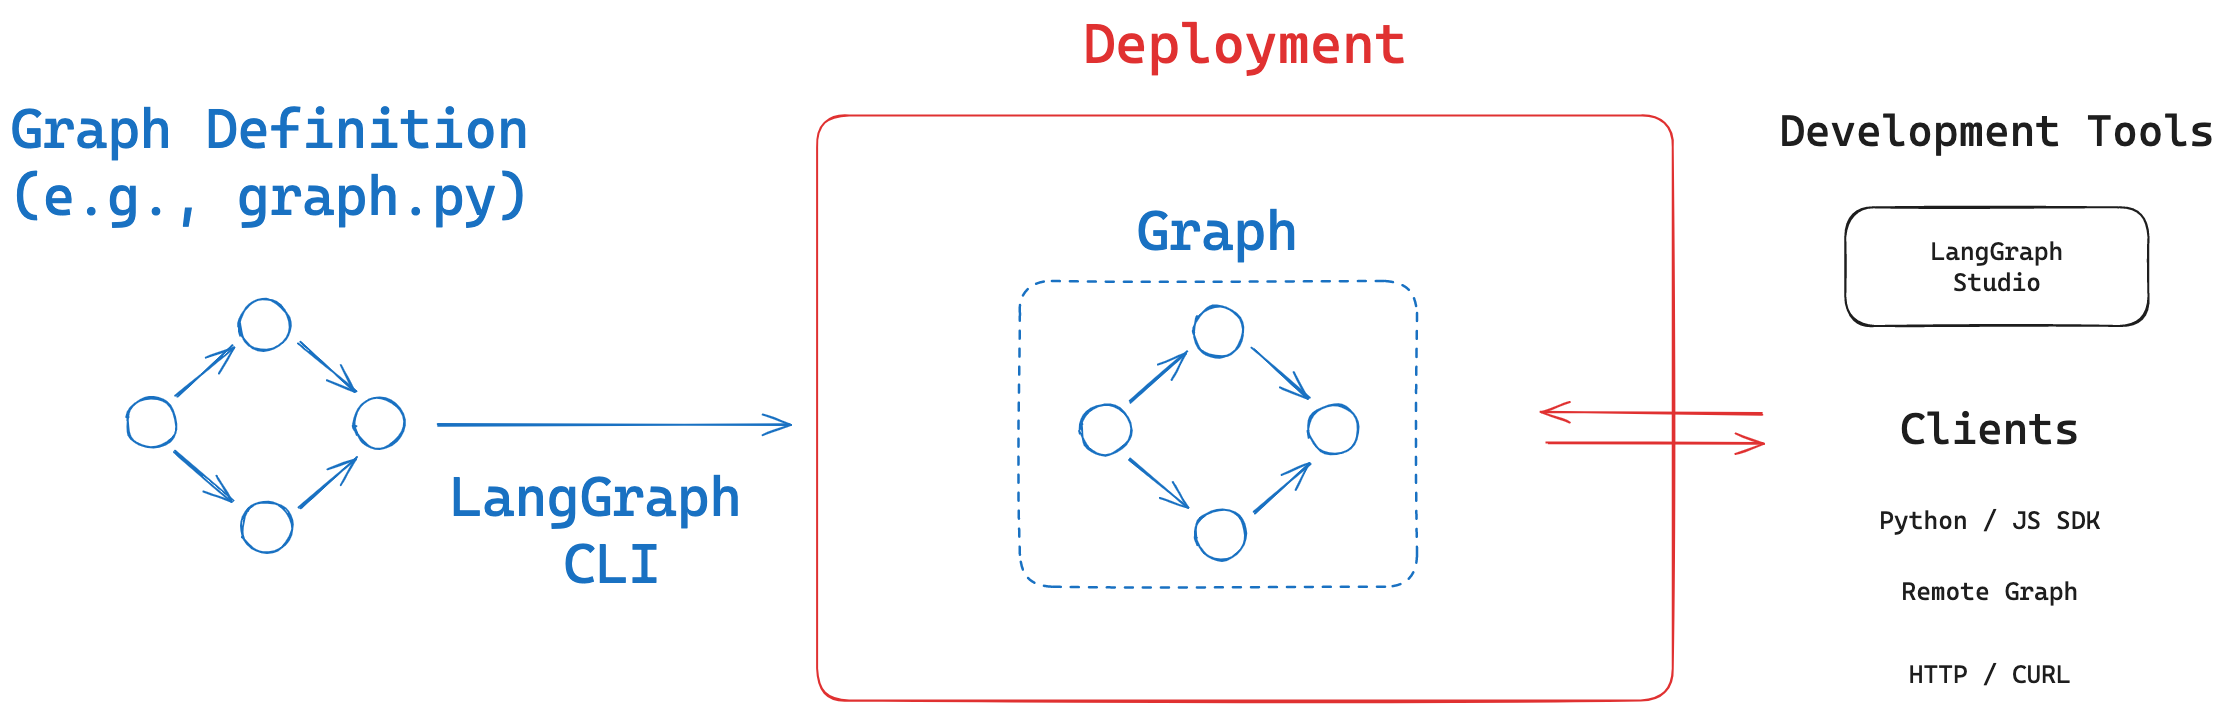

## Using the API  

LangGraph Server exposes [many API endpoints](https://github.com/langchain-ai/agent-protocol) for interacting with the deployed agent.

We can group [these endpoints into a few common agent needs](https://github.com/langchain-ai/agent-protocol): 

* **Runs**: Atomic agent executions
* **Threads**: Multi-turn interactions or human in the loop
* **Store**: Long-term memory

We can test requests directly [in the API docs](http://localhost:8123/docs#tag/thread-runs).

## SDK

The [LangGraph SDKs](https://docs.langchain.com/langsmith/sdk) (Python and JS) provide a developer-friendly interface to interact with the LangGraph Server API presented above.

In [ ]:
%%capture --no-stderr
%pip install -U langgraph_sdk

In [3]:
from langgraph_sdk import get_client

# Connect via SDK
url_for_cli_deployment = "http://localhost:8123"
client = get_client(url=url_for_cli_deployment)

## Remote Graph

If you are working in the LangGraph library, [Remote Graph](https://docs.langchain.com/langsmith/use-remote-graph) is also a useful way to connect directly to the graph.

In [8]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph langchain_core

In [4]:
from langgraph.pregel.remote import RemoteGraph
from langchain_core.messages import convert_to_messages
from langchain_core.messages import HumanMessage, SystemMessage

# Connect via remote graph
url = "http://localhost:8123"
graph_name = "task_maistro" 
remote_graph = RemoteGraph(graph_name, url=url)

## Runs

A "run" represents a [single execution](https://github.com/langchain-ai/agent-protocol?tab=readme-ov-file#runs-atomic-agent-executions) of your graph. Each time a client makes a request:

1. The HTTP worker generates a unique run ID
2. This run and its results are stored in PostgreSQL
3. You can query these runs to:
   - Check their status
   - Get their results
   - Track execution history

You can see a full set of How To guides for various types of runs [here](https://langchain-ai.github.io/langgraph/how-tos/#runs).

Let's looks at a few of the interesting things we can do with runs.

### Background Runs

The LangGraph server supports two types of runs: 

* `Fire and forget` - Launch a run in the background, but don’t wait for it to finish
* `Waiting on a reply (blocking or polling)` - Launch a run and wait/stream its output

Background runs and polling are quite useful when working with long-running agents. 

Let's [see](https://docs.langchain.com/langsmith/background-run) how this works:

In [6]:
# Create a thread
thread = await client.threads.create()
thread

{'thread_id': '7f71c0dd-768b-4e53-8349-42bdd10e7caf',
 'created_at': '2024-11-14T19:36:08.459457+00:00',
 'updated_at': '2024-11-14T19:36:08.459457+00:00',
 'metadata': {},
 'status': 'idle',
 'config': {},
 'values': None}

In [7]:
# Check any existing runs on a thread
thread = await client.threads.create()
runs = await client.runs.list(thread["thread_id"])
print(runs)

[]


In [8]:
# Ensure we've created some ToDos and saved them to my user_id
user_input = "Add a ToDo to finish booking travel to Hong Kong by end of next week. Also, add a ToDo to call parents back about Thanksgiving plans."
config = {"configurable": {"user_id": "Test"}}
graph_name = "task_maistro" 
run = await client.runs.create(thread["thread_id"], graph_name, input={"messages": [HumanMessage(content=user_input)]}, config=config)

In [9]:
# Kick off a new thread and a new run
thread = await client.threads.create()
user_input = "Give me a summary of all ToDos."
config = {"configurable": {"user_id": "Test"}}
graph_name = "task_maistro" 
run = await client.runs.create(thread["thread_id"], graph_name, input={"messages": [HumanMessage(content=user_input)]}, config=config)

In [10]:
# Check the run status
print(await client.runs.get(thread["thread_id"], run["run_id"]))

{'run_id': '1efa2c00-63e4-6f4a-9c5b-ca3f5f9bff07', 'thread_id': '641c195a-9e31-4250-a729-6b742c089df8', 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21', 'created_at': '2024-11-14T19:38:29.394777+00:00', 'updated_at': '2024-11-14T19:38:29.394777+00:00', 'metadata': {}, 'status': 'pending', 'kwargs': {'input': {'messages': [{'id': None, 'name': None, 'type': 'human', 'content': 'Give me a summary of all ToDos.', 'example': False, 'additional_kwargs': {}, 'response_metadata': {}}]}, 'config': {'metadata': {'created_by': 'system'}, 'configurable': {'run_id': '1efa2c00-63e4-6f4a-9c5b-ca3f5f9bff07', 'user_id': 'Test', 'graph_id': 'task_maistro', 'thread_id': '641c195a-9e31-4250-a729-6b742c089df8', 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'}}, 'webhook': None, 'subgraphs': False, 'temporary': False, 'stream_mode': ['values'], 'feedback_keys': None, 'interrupt_after': None, 'interrupt_before': None}, 'multitask_strategy': 'reject'}


We can see that it has `'status': 'pending'` because it is still running.

What if we want to wait until the run completes, making it a blocking run?

We can use `client.runs.join` to wait until the run completes.

This ensures that no new runs are started until the current run completes on the thread.

In [11]:
# Wait until the run completes
await client.runs.join(thread["thread_id"], run["run_id"])
print(await client.runs.get(thread["thread_id"], run["run_id"]))

{'run_id': '1efa2c00-63e4-6f4a-9c5b-ca3f5f9bff07', 'thread_id': '641c195a-9e31-4250-a729-6b742c089df8', 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21', 'created_at': '2024-11-14T19:38:29.394777+00:00', 'updated_at': '2024-11-14T19:38:29.394777+00:00', 'metadata': {}, 'status': 'success', 'kwargs': {'input': {'messages': [{'id': None, 'name': None, 'type': 'human', 'content': 'Give me a summary of all ToDos.', 'example': False, 'additional_kwargs': {}, 'response_metadata': {}}]}, 'config': {'metadata': {'created_by': 'system'}, 'configurable': {'run_id': '1efa2c00-63e4-6f4a-9c5b-ca3f5f9bff07', 'user_id': 'Test', 'graph_id': 'task_maistro', 'thread_id': '641c195a-9e31-4250-a729-6b742c089df8', 'assistant_id': 'ea4ebafa-a81d-5063-a5fa-67c755d98a21'}}, 'webhook': None, 'subgraphs': False, 'temporary': False, 'stream_mode': ['values'], 'feedback_keys': None, 'interrupt_after': None, 'interrupt_before': None}, 'multitask_strategy': 'reject'}


Now the run has `'status': 'success'` because it has completed.

### Streaming Runs

Each time a client makes a streaming request:

1. The HTTP worker generates a unique run ID
2. The Queue worker begins work on the run 
3. During execution, the Queue worker publishes update to Redis
4. The HTTP worker subscribes to updates from Redis for ths run, and returns them to the client 

This enabled streaming! 

We've covered [streaming](https://langchain-ai.github.io/langgraph/how-tos/#streaming_1) in previous modules, but let's pick one method -- streaming tokens -- to highlight.

Streaming tokens back to the client is especially useful when working with production agents that may take a while to complete.

We [stream tokens](https://docs.langchain.com/langsmith/streaming) using `stream_mode="messages-tuple"`.

In [12]:
user_input = "What ToDo should I focus on first."
async for chunk in client.runs.stream(thread["thread_id"], 
                                      graph_name, 
                                      input={"messages": [HumanMessage(content=user_input)]},
                                      config=config,
                                      stream_mode="messages-tuple"):

    if chunk.event == "messages":
        print("".join(data_item['content'] for data_item in chunk.data if 'content' in data_item), end="", flush=True)

You might want to focus on "Call parents back about Thanksgiving plans" first. It has a shorter estimated time to complete (15 minutes) and doesn't have a specific deadline, so it could be a quick task to check off your list. Once that's done, you can dedicate more time to "Finish booking travel to Hong Kong," which is more time-consuming and has a deadline.

## Threads

Whereas a run is only a single execution of the graph, a thread supports *multi-turn* interactions.

When the client makes a graph execution execution with a `thread_id`, the server will save all [checkpoints](https://docs.langchain.com/oss/python/langgraph/persistence#checkpoints) (steps) in the run to the thread in the Postgres database.

The server allows us <!-- to  [~check the status of created threads~](https://langchain-ai.github.io/langgraph/cloud/how-tos/check_thread_status/) -->
a variety of ways to [work with threads](https://reference.langchain.com/python/langsmith/deployment/sdk/#langgraph_sdk.client.ThreadsClient).

### Check thread state

For example, we can easily access the state [checkpoints](https://docs.langchain.com/oss/python/langgraph/persistence#checkpoints) saved to any specific thread.

In [13]:
thread_state = await client.threads.get_state(thread['thread_id'])
for m in convert_to_messages(thread_state['values']['messages']):
    m.pretty_print()

================================ Human Message =================================

Give me a summary of all ToDos.
================================== Ai Message ==================================

Here's a summary of your current ToDo list:

1. **Task:** Finish booking travel to Hong Kong
   - **Status:** Not started
   - **Deadline:** November 22, 2024
   - **Solutions:** 
     - Check flight prices on Skyscanner
     - Book hotel through Booking.com
     - Arrange airport transfer
   - **Estimated Time to Complete:** 120 minutes

2. **Task:** Call parents back about Thanksgiving plans
   - **Status:** Not started
   - **Deadline:** None
   - **Solutions:** 
     - Check calendar for availability
     - Discuss travel arrangements
     - Confirm dinner plans
   - **Estimated Time to Complete:** 15 minutes

Let me know if there's anything else you'd like to do with your ToDo list!
================================ Human Message =================================

What ToDo should I focus 

### Copy threads

We can also [copy](https://docs.langchain.com/langsmith/use-threads#copy-thread) (i.e. "fork") an existing thread. 

This will keep the existing thread's history, but allow us to create independent runs that do not affect the original thread.

In [14]:
# Copy the thread
copied_thread = await client.threads.copy(thread['thread_id'])

In [15]:
# Check the state of the copied thread
copied_thread_state = await client.threads.get_state(copied_thread['thread_id'])
for m in convert_to_messages(copied_thread_state['values']['messages']):
    m.pretty_print()

================================ Human Message =================================

Give me a summary of all ToDos.
================================== Ai Message ==================================

Here's a summary of your current ToDo list:

1. **Task:** Finish booking travel to Hong Kong
   - **Status:** Not started
   - **Deadline:** November 22, 2024
   - **Solutions:** 
     - Check flight prices on Skyscanner
     - Book hotel through Booking.com
     - Arrange airport transfer
   - **Estimated Time to Complete:** 120 minutes

2. **Task:** Call parents back about Thanksgiving plans
   - **Status:** Not started
   - **Deadline:** None
   - **Solutions:** 
     - Check calendar for availability
     - Discuss travel arrangements
     - Confirm dinner plans
   - **Estimated Time to Complete:** 15 minutes

Let me know if there's anything else you'd like to do with your ToDo list!
================================ Human Message =================================

What ToDo should I focus 

### Human in the loop

We covered [Human in the loop](https://docs.langchain.com/langsmith/add-human-in-the-loop) in Module 3, and the server supports all Human in the loop features that we discussed.

As an example, [we can search, edit, and continue graph execution](https://docs.langchain.com/oss/python/langgraph/persistence#capabilities) from any prior checkpoint. 

In [16]:
# Get the history of the thread
states = await client.threads.get_history(thread['thread_id'])

# Pick a state update to fork
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Give me a summary of all ToDos.',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '3680da45-e3a5-4a47-b5b1-4fd4d3e8baf9',
   'example': False}]}

In [17]:
to_fork['values']['messages'][0]['id']

'3680da45-e3a5-4a47-b5b1-4fd4d3e8baf9'

In [18]:
to_fork['next']

['task_mAIstro']

In [19]:
to_fork['checkpoint_id']

'1efa2c00-6609-67ff-8000-491b1dcf8129'

Let's edit the state. Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [20]:
forked_input = {"messages": HumanMessage(content="Give me a summary of all ToDos that need to be done in the next week.",
                                         id=to_fork['values']['messages'][0]['id'])}

# Update the state, creating a new checkpoint in the thread
forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [21]:
# Run the graph from the new checkpoint in the thread
async for chunk in client.runs.stream(thread["thread_id"], 
                                      graph_name, 
                                      input=None,
                                      config=config,
                                      checkpoint_id=forked_config['checkpoint_id'],
                                      stream_mode="messages-tuple"):

    if chunk.event == "messages":
        print("".join(data_item['content'] for data_item in chunk.data if 'content' in data_item), end="", flush=True)

Here's a summary of your ToDos that need to be done in the next week:

1. **Finish booking travel to Hong Kong**
   - **Status:** Not started
   - **Deadline:** November 22, 2024
   - **Solutions:** 
     - Check flight prices on Skyscanner
     - Book hotel through Booking.com
     - Arrange airport transfer
   - **Estimated Time to Complete:** 120 minutes

It looks like this task is due soon, so you might want to prioritize it. Let me know if there's anything else you need help with!

## Across-thread memory

In module 5, we covered how the [LangGraph memory `store`](https://docs.langchain.com/oss/python/langgraph/persistence#memory-store) can be used to save information across threads.

Our deployed graph, `task_maistro`, uses the `store` to save information -- such as ToDos -- namespaced to the `user_id`.

Our deployment includes a Postgres database, which stores these long-term (across-thread) memories.

There are several methods available [for interacting with the store](https://reference.langchain.com/python/langsmith/deployment/sdk/#langgraph_sdk.client.StoreClient) in our deployment using the LangGraph SDK.

### Search items

The `task_maistro` graph uses the `store` to save ToDos namespaced by default to (`todo`, `todo_category`, `user_id`). 

The `todo_category` is by default set to `general` (as you can see in `deployment/configuration.py`).

We can simply supply this tuple to search for all ToDos. 

In [29]:
items = await client.store.search_items(
    ("todo", "general", "Test"),
    limit=5,
    offset=0
)
items['items']

[{'value': {'task': 'Finish booking travel to Hong Kong',
   'status': 'not started',
   'deadline': '2024-11-22T23:59:59',
   'solutions': ['Check flight prices on Skyscanner',
    'Book hotel through Booking.com',
    'Arrange airport transfer'],
   'time_to_complete': 120},
  'key': '18524803-c182-49de-9b10-08ccb0a06843',
  'namespace': ['todo', 'general', 'Test'],
  'created_at': '2024-11-14T19:37:41.664827+00:00',
  'updated_at': '2024-11-14T19:37:41.664827+00:00'},
 {'value': {'task': 'Call parents back about Thanksgiving plans',
   'status': 'not started',
   'deadline': None,
   'solutions': ['Check calendar for availability',
    'Discuss travel arrangements',
    'Confirm dinner plans'],
   'time_to_complete': 15},
  'key': '375d9596-edf8-4de2-985b-bacdc623d6ef',
  'namespace': ['todo', 'general', 'Test'],
  'created_at': '2024-11-14T19:37:41.664827+00:00',
  'updated_at': '2024-11-14T19:37:41.664827+00:00'}]

### Add items

In our graph, we call `put` to add items to the store.

We can use [put](https://reference.langchain.com/python/langsmith/deployment/sdk/#langgraph_sdk.client.StoreClient.put_item) with the SDK if we want to directly add items to the store outside our graph.

In [30]:
from uuid import uuid4
await client.store.put_item(
    ("testing", "Test"),
    key=str(uuid4()),
    value={"todo": "Test SDK put_item"},
)

In [31]:
items = await client.store.search_items(
    ("testing", "Test"),
    limit=5,
    offset=0
)
items['items']

[{'value': {'todo': 'Test SDK put_item'},
  'key': '3de441ba-8c79-4beb-8f52-00e4dcba68d4',
  'namespace': ['testing', 'Test'],
  'created_at': '2024-11-14T19:56:30.452808+00:00',
  'updated_at': '2024-11-14T19:56:30.452808+00:00'},
 {'value': {'todo': 'Test SDK put_item'},
  'key': '09b9a869-4406-47c5-a635-4716bd79a8b3',
  'namespace': ['testing', 'Test'],
  'created_at': '2024-11-14T19:53:24.812558+00:00',
  'updated_at': '2024-11-14T19:53:24.812558+00:00'}]

### Delete items

We can use the SDK to [delete items](https://reference.langchain.com/python/langsmith/deployment/sdk/#langgraph_sdk.client.StoreClient.delete_item) from the store by key.

In [32]:
[item['key'] for item in items['items']]

['3de441ba-8c79-4beb-8f52-00e4dcba68d4',
 '09b9a869-4406-47c5-a635-4716bd79a8b3']

In [33]:
await client.store.delete_item(
       ("testing", "Test"),
        key='3de441ba-8c79-4beb-8f52-00e4dcba68d4',
    )

In [34]:
items = await client.store.search_items(
    ("testing", "Test"),
    limit=5,
    offset=0
)
items['items']

[{'value': {'todo': 'Test SDK put_item'},
  'key': '09b9a869-4406-47c5-a635-4716bd79a8b3',
  'namespace': ['testing', 'Test'],
  'created_at': '2024-11-14T19:53:24.812558+00:00',
  'updated_at': '2024-11-14T19:53:24.812558+00:00'}]